In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [7]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [71]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 25
action_types = ('grenade', 'reload')
data_depth = 6

def load_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    for action_type in action_types:

        for i in range(1, 100, 1):
            # if file exists
            if not isfile(data_dir + f"/{action_type}{i}.csv"):
                break
            data = load_data(data_dir + f"/{action_type}{i}.csv")

            # sliding window
            for j in range(0, len(data) - window_size+1, window_stride):
                dataset_x.append(data[j:j + window_size])
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_x = np.float32(dataset_x)/32
    dataset_y = to_categorical(dataset_y)
    return np.array(dataset_x), np.array(dataset_y)

# load dataset
dataset_x, dataset_y = load_dataset("Dataset")

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y)

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Dataset initialized with size: 58
Class 0 has 11 samples
Class 1 has 47 samples

Test set distribution
Class 0 has 2 samples
Class 1 has 10 samples


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 11, 16)            2416      
                                                                 
 dropout_6 (Dropout)         (None, 11, 16)            0         
                                                                 
 flatten_6 (Flatten)         (None, 176)               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 354       
                                                                 
Total params: 2,770
Trainable params: 2,770
Non-trainable params: 0
_________________________________________________________________


2022-09-10 16:55:53.051629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


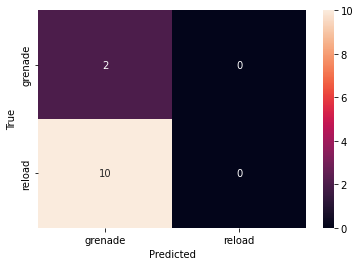

In [72]:
conv1filters = 16
conv1kernel = 25
conv1stride = 5

model = Sequential()
model.add(Conv1D(conv1filters, conv1kernel, strides=conv1stride, activation='relu', input_shape=(window_size, 6)))
model.add(Dropout(0.5)) # 50% dropout
# model.add(Conv1D(32, 40, activation='relu', data_format='channels_first'))
model.add(Flatten())
# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# performance before training
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [73]:
# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [74]:
# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 100
    batch_size = 32
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), callbacks = [model_checkpoint_callback, reduce_lr, early_stopping], verbose=verbose)
    _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
    return model

model = train_network(model, train_x, train_y, test_x, test_y)

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 78.6695 - accuracy: 0.3750

2022-09-10 16:55:54.798719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-09-10 16:55:54.967747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 123ms/step - loss: 84.4004 - accuracy: 0.3913 - val_loss: 29.4682 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 40ms/step - loss: 60.7023 - accuracy: 0.4348 - val_loss: 20.7988 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 34.1403 - accuracy: 0.6087 - val_loss: 14.7549 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 17.9648 - accuracy: 0.6957 - val_loss: 10.4405 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 13.3464 - accuracy: 0.8478 - val_loss: 5.5132 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 39ms/step - loss: 10.6552 - accuracy: 0.8043 - val_loss: 1.1666 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 38ms/step - loss: 4.8583 - ac

# Draw confusion matrix

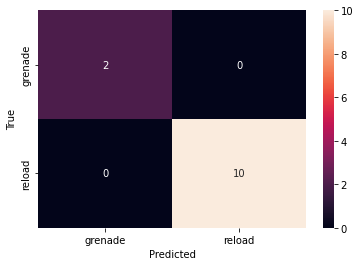

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_weights(checkpoint_filepath)
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [80]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[3].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[3].output_shape}")

window shape: (75, 6)
kernel shape: (25, 6)
first layer weights shape: (25, 6, 16)
first layer output shape: (None, 11, 16)
second layer weights shape: (176, 2)
second layer output shape: (None, 2)
